In [1]:
import numpy
import corner
from galpy.util import bovy_plot
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Fitting a linear regression with outliers with various tools

We explore the use of various standard inference and MCMC tools with the example of the Hogg, Bovy, & Lang data. This data can be fit with a straight line + outliers. This is a simple, but somewhat non-trivial model that stretches the ability of most of the modeling frameworks that we consider below. Specifically, we use

* ``emcee``
* ``stan``
* ``pymc3``
* ``tensorflow`` (for optimization)

The data is the following:

In [2]:
data= numpy.array([[1,201,592,61,9,-0.84],
                   [2,244,401,25,4,0.31],
                   [3,47,583,38,11,0.64],
                   [4,287,402,15,7,-0.27],
                   [5,203,495,21,5,-0.33],
                   [6,58,173,15,9,0.67],
                   [7,210,479,27,4,-0.02],
                   [8,202,504,14,4,-0.05],
                   [9,198,510,30,11,-0.84],
                   [10,158,416,16,7,-0.69],
                   [11,165,393,14,5,0.30],
                   [12,201,442,25,5,-0.46],
                   [13,157,317,52,5,-0.03],
                   [14,131,311,16,6,0.50],
                   [15,166,400,34,6,0.73],
                   [16,160,337,31,5,-0.52],
                   [17,186,423,42,9,0.90],
                   [18,125,334,26,8,0.40],
                   [19,218,533,16,6,-0.78],
                   [20,146,344,22,5,-0.56]])

In [3]:
# Basic linear fit used as initialization
def linfit(y,x,yerr):
    # Generate Y and X arrays
    A= numpy.vander(x,N=2)
    Cinv= numpy.diag(1./yerr**2.)
    Y= numpy.dot(A.T,numpy.dot(Cinv,y))
    A= numpy.dot(A.T,numpy.dot(Cinv,A))
    return (numpy.linalg.solve(A,Y),numpy.linalg.inv(A))

## using ``emcee``

In [4]:
import emcee

In ``emcee``, we explicitly define the log posterior and sample it. The ln PDF is given by the following function:

In [5]:
# The PDF
def lnprob(x,data):
    # Parameters: m,b,Pb,Yb,lnVb
    if x[2] < 0: return -1000000000000.
    if x[2] > 1: return -1000000000000.
    if numpy.exp(x[4]/2.) > 10000.:  return -1000000000000.
    if numpy.exp(x[4]/2.) < 1.:  return -1000000000000.
    return numpy.sum(\
        numpy.log((1.-x[2])/data[:,3]*numpy.exp(-0.5*(data[:,2]-x[0]*data[:,1]-x[1])**2./\
                                               data[:,3]**2.)
                 +x[2]/numpy.sqrt(data[:,3]**2.+numpy.exp(x[4]))\
                         *numpy.exp(-0.5*(data[:,2]-x[3])**2./(data[:,3]**2.+numpy.exp(x[4])))))

In [6]:
nwalkers= 20
# Start from best-fit line above
X, Xcov= linfit(data[4:,2],data[4:,1],data[4:,3])
p0= [[X[0]+numpy.random.normal()*numpy.sqrt(Xcov[0,0]),
      X[1]+numpy.random.normal()*numpy.sqrt(Xcov[1,1]),
      0.3+(numpy.random.uniform()/5.-0.1),
      numpy.mean(data[:,2])+numpy.random.normal()*numpy.std(data[:,2])/4.,
     (2.*numpy.log(numpy.std(data[:,2]))*(1.+0.1*numpy.random.normal()))]
    for w in range(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers,len(p0[0]),lnprob,args=[data])
# Burn=in
pos, prob, state = sampler.run_mcmc(p0,1000)
sampler.reset()
pos, prob, state= sampler.run_mcmc(pos,10000)

A ``corner.py`` plot of the posterior samples:

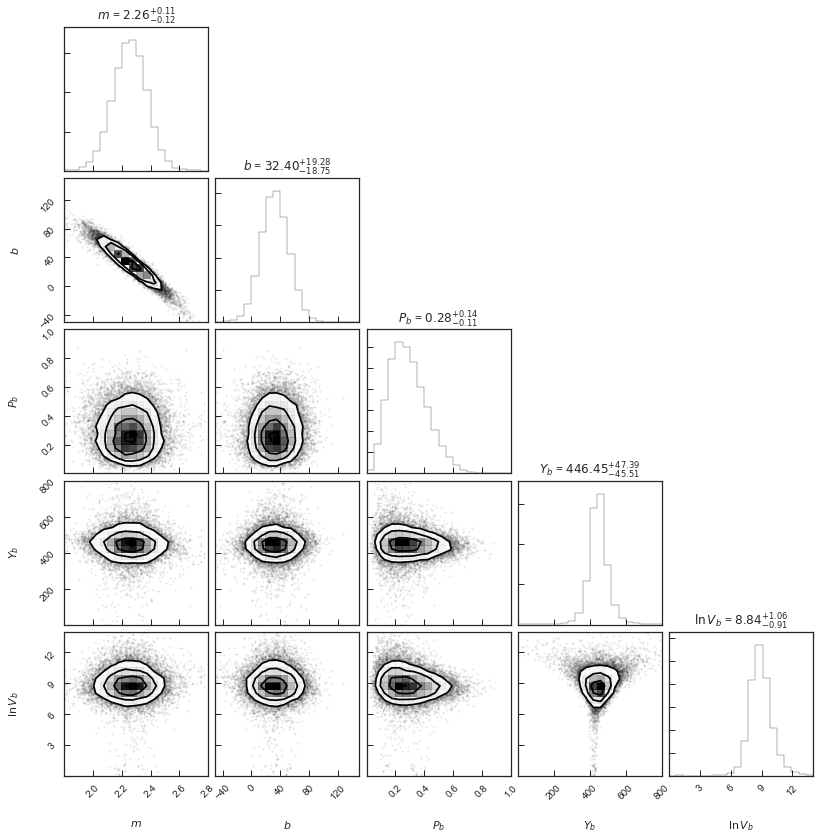

In [7]:
fig = corner.corner(sampler.flatchain[::10],
                    labels=["$m$", "$b$", "$P_b$", "$Y_b$","$\ln\,V_b$"],
                    range=[(1.8,2.8),(-50.,150.),(0.,1.),(0.,800.),(0.,14.)],
                    show_titles=True)

## Using ``stan``

In [8]:
import pystan

In ``stan``, we first write down the model using the ``stan`` modeling code. We first implement the simple model of a straight line without outliers. Note that we don't have to explicitly write down the posterior, we simply state that the the *y* data should be normally distributed around the model line:

In [9]:
stan_code = """
data {
    int<lower=0> N; // number of data points
    real x[N]; // x data
    real y[N]; // y data
    real<lower=0> sigma[N]; // uncertainties in the data
}
parameters {
    real m;
    real b;
}
transformed parameters {
    real y_pred[N];
    for (n in 1:N)
    y_pred[n] <- b + m * x[n];
}
model {
    y ~ normal(y_pred,sigma);
}
"""
fit = pystan.stan(model_code=stan_code,
                  data=dict(N=len(data)-4,
                            x=data[4:,1],
                            y=data[4:,2],
                            sigma=data[4:,3]),
                  iter=1000,chains=4)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_b709445de992611c46dea81d0cd93a11 NOW.


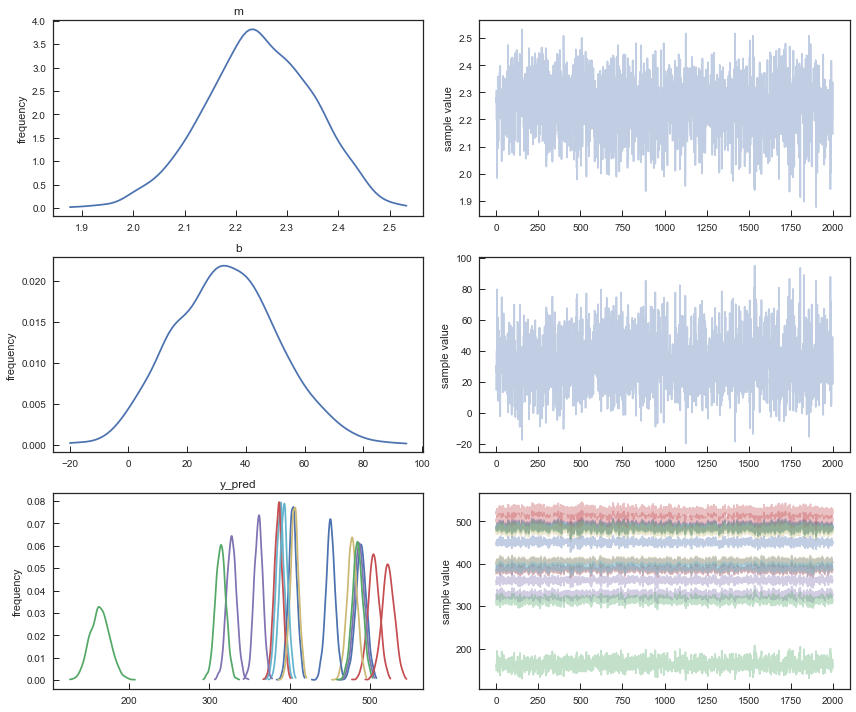

In [10]:
figsize(12,10)
fit.plot()
tight_layout()

We get the expected result:

In [11]:
print("b=%.2f, m=%.2f" % (numpy.median(fit.extract()['b']), numpy.median(fit.extract()['m'])))

b=33.02, m=2.24


Now we write down the mixture model for the outliers. In this case, we need to explicitly write down that each data point is drawn from the mixture of inlier model (straight line) and the outlier model (wide Gaussian). Note that ``stan`` is extremely unstable when we convolve the outlier model with each data point's uncertainty, so we don't actually convolve the outlier model with the data uncertainties (which are much smaller than the outlier model's standard deviation anyway):

In [12]:
stan_code = """
data {
    int<lower=0> N; // number of data points
    real x[N]; // x data
    real y[N]; // y data
    real<lower=0> sigma[N]; // uncertainties in the data
}
parameters {
    real m;
    real b;
    real<lower=0,upper=1.> Pb;
    real Yb;
    real lnVb;
}
transformed parameters {
    real sb;
    real y_pred[N];
    for (n in 1:N)
        y_pred[n] = b + m * x[n];
    sb= exp(lnVb/2.); // We simplify convolution to sigma_out[n]=~ sqrt(Vb) rather than sqrt(Vb+sigma[n]^2)
}
model {
    real ps[2]; // temporary variable for p_in and p_out
    for (n in 1:N){
        ps[1] = log(1.-Pb) + normal_lpdf(y[n] | y_pred[n],sigma[n]);
        ps[2] = log(Pb)    + normal_lpdf(y[n] | Yb       ,sb);
        target += log_sum_exp(ps);
    }
}
"""
fit = pystan.stan(model_code=stan_code,
                  data=dict(N=len(data),
                            x=data[:,1],
                            y=data[:,2],
                            sigma=data[:,3]),
                  iter=10000,chains=4)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_3da58f7d6d633aad1f03e5de0f346eee NOW.


``stan`` provides both textual and visual summaries of the inference:

In [13]:
print(fit)

Inference for Stan model: anon_model_3da58f7d6d633aad1f03e5de0f346eee.
4 chains, each with iter=10000; warmup=5000; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=20000.

             mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
m            2.25  1.4e-3   0.12   2.01   2.18   2.25   2.33   2.48   7777    1.0
b           32.71    0.23  19.92  -5.54   20.2  32.72  45.55   71.2   7450    1.0
Pb           0.28  1.2e-3   0.12   0.09   0.19   0.27   0.36   0.56  10711    1.0
Yb         453.25    3.04 107.34 303.02 416.54  452.7 488.48  598.8   1248    1.0
lnVb         9.39    0.02    1.0   7.92   8.72   9.24   9.87  11.76   3552    1.0
sb         129.31     3.6 135.97  52.35  78.35 101.48 139.25 358.13   1429    1.0
y_pred[0]  485.42    0.07   8.18  468.7 480.45 485.71 490.75 500.58  13821    1.0
y_pred[1]  582.27    0.12  12.25  557.3 574.84 582.63 590.28 605.48  10258    1.0
y_pred[2]  138.57    0.17  14.61 110.24 129.41 138.57 148.04 166.84   7

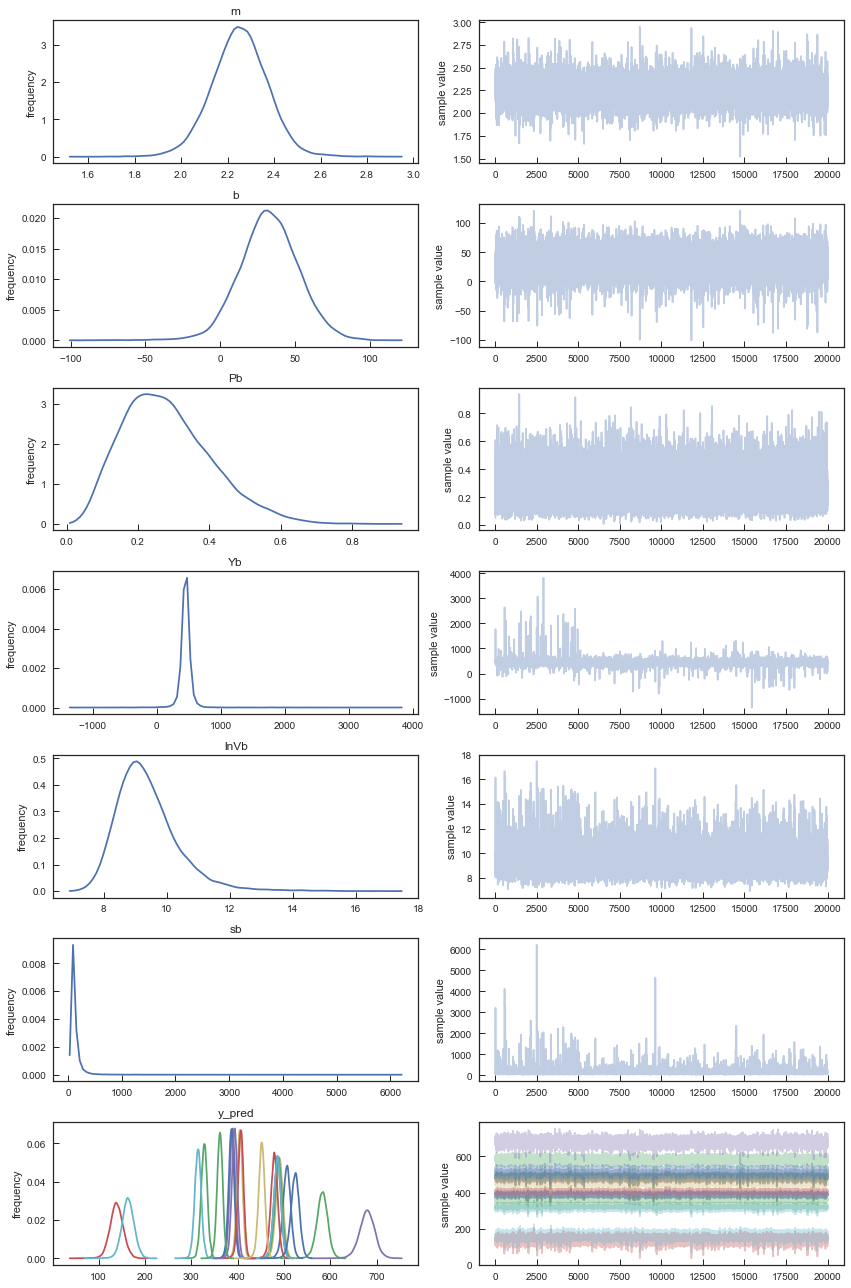

In [14]:
figsize(12,18)
fit.plot()
tight_layout()

``stan`` produces the same posterior sampling as ``emcee`` above, see the following ``corner.py`` plot:

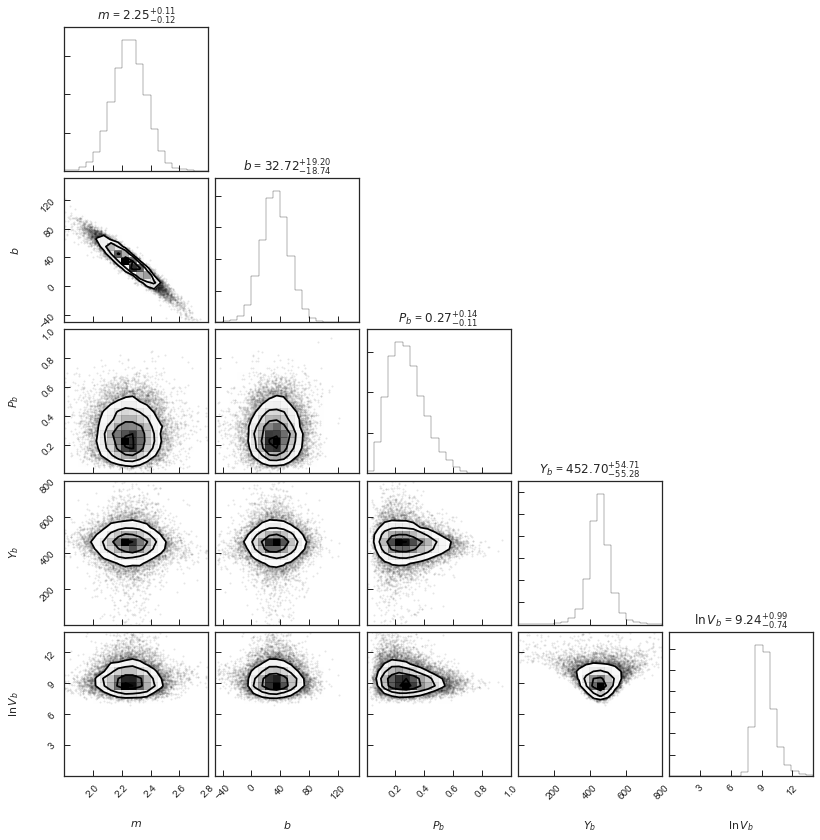

In [15]:
fig = corner.corner(numpy.array([fit.extract()['m'],fit.extract()['b'],
                                 fit.extract()['Pb'],fit.extract()['Yb'],fit.extract()['lnVb']]).T,
                    labels=["$m$", "$b$", "$P_b$", "$Y_b$","$\ln\,V_b$"],
                    range=[(1.8,2.8),(-50.,150.),(0.,1.),(0.,800.),(0.,14.)],
                   show_titles=True)

## Using ``pymc3``

In [16]:
import pymc3

In ``pymc3`` we also need to write down the model in the, python-based, modeling language of ``pymc3``. We again first do the regular straight-line fit:

In [17]:
basic_model = pymc3.Model()
with basic_model:
    # Priors for unknown model parameters
    m= pymc3.Normal('m', mu=0, sd=10)
    b= pymc3.Normal('b', mu=0, sd=1000)
    # Expected value of outcome
    y_pred= b+m*data[4:,1]
    # Likelihood (sampling distribution) of observations
    Y_obs= pymc3.Normal('Y_obs',mu=y_pred,sd=data[4:,3],observed=data[4:,2])
    print(pymc3.find_MAP(model=basic_model))

Optimization terminated successfully.
         Current function value: 85.380047
         Iterations: 5
         Function evaluations: 9
         Gradient evaluations: 9
{'m': array(2.2397250490976486), 'b': array(34.07870283902483)}


Next we write down the model of a straight line + Gaussian outlier model. This took me *forever* to figure out! Also not sure what I did wrong in writing down the model, because the default NUTS sampler is incredibly slow for this problem (``stan`` above had no problems with this), so the following code uses Metropolis-Hastings. For simplicity and to compare to ``stan``, we again don't convolve the outlier model with the uncertainties:

In [18]:
import theano.tensor as tt
class lineplusoutlier(pymc3.distributions.Continuous):
    """Model of a straight line + outlier Gaussian"""
    def __init__(self,m,b,Pb,Yb,lnVb,sd,x,*args,**kwargs):
        super(lineplusoutlier, self).__init__(*args, **kwargs)
        self.m= m
        self.b= b
        self.Pb= Pb
        self.Yb= Yb
        self.lnVb= lnVb
        self.x= x
        self.sd= sd
    def logp(self,value):
        return tt.log((1.-self.Pb)/self.sd*tt.exp(-0.5*(value-self.m*self.x-self.b)**2./self.sd**2.)
                        +self.Pb*tt.exp(-0.5*(self.lnVb+(value-self.Yb)**2.*tt.exp(-self.lnVb))))
basic_model = pymc3.Model()
with basic_model:
    # Priors for unknown model parameters
    m= pymc3.Normal('m', mu=0, sd=10)
    b= pymc3.Normal('b', mu=numpy.median(data[:,2]), sd=1000)
    Pb= pymc3.Uniform('Pb',lower=0.,upper=1.)
    Yb= pymc3.Normal('Yb', mu=numpy.median(data[:,2]),sd=1000)
    lnVb= pymc3.Normal('lnVb', mu=2.*numpy.log(numpy.std(data[:,2])),sd=4.)
    # Mixture in+out
    Y_obs= lineplusoutlier('Y_obs',m,b,Pb,Yb,lnVb,data[:,3],data[:,1],
                          observed=data[:,2])
    step = pymc3.Metropolis()
    trace = pymc3.sample(20000,tune=2000,init='map',step=step)

100%|██████████| 20000/20000 [00:13<00:00, 1476.75it/s]


Like ``stan``, ``pymc3`` has some fancy plotting of the output:

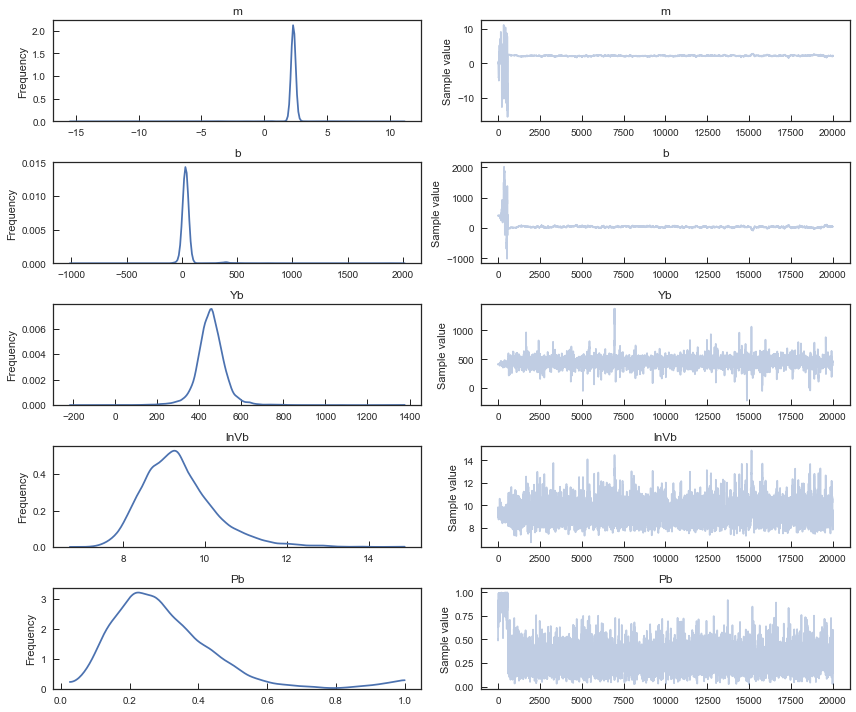

In [19]:
pymc3.traceplot(trace);

The ``corner.py`` plot of the samples is incredibly similar to those produced by ``emcee`` and ``stan`` above:

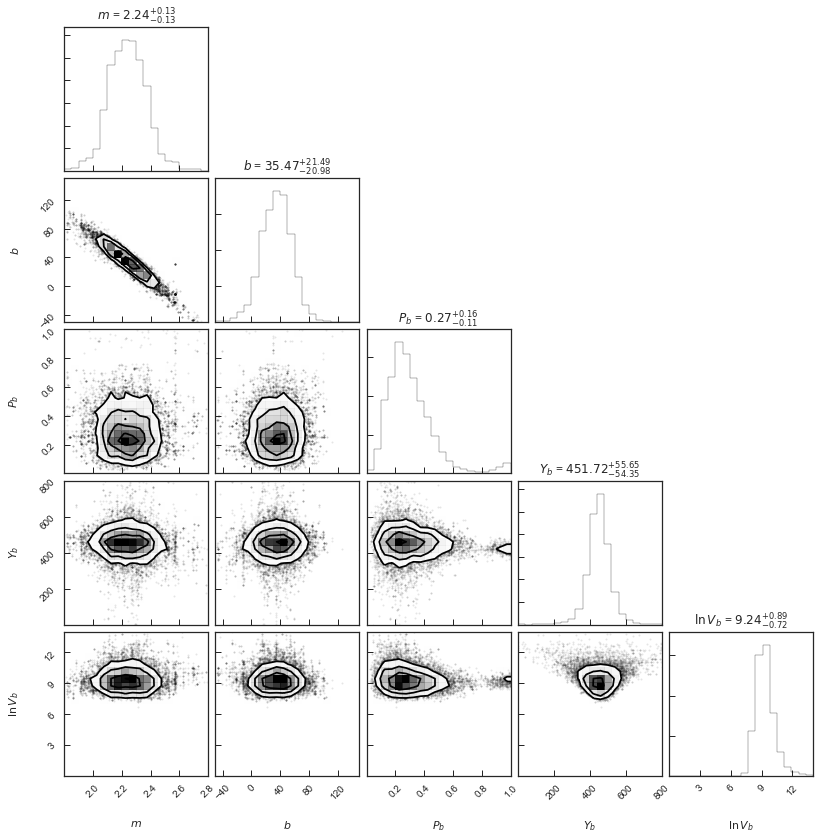

In [20]:
fig = corner.corner(numpy.array([trace['m'],trace['b'],trace['Pb'],trace['Yb'],trace['lnVb']]).T,
                    labels=["$m$", "$b$", "$P_b$", "$Y_b$","$\ln\,V_b$"],
                    range=[(1.8,2.8),(-50.,150.),(0.,1.),(0.,800.),(0.,14.)],
                   show_titles=True)

## Using ``tensorflow``

In [21]:
import tensorflow as tf

``tensorflow`` can be used to find the best-fit (not, AFAIK, to get the PDF; this should be possible with ``edward``). So let's try this out! First we do the simple straight-line fit. We define the model, the placeholders for the data, and the loss function:

In [22]:
m= tf.Variable([0.2], dtype=tf.float64)
b= tf.Variable([0.], dtype=tf.float64)
x= tf.placeholder(tf.float64)
linear_model= m*x+b

In [23]:
y= tf.placeholder(tf.float64)
sigma= tf.placeholder(tf.float64)
squared_deltas= tf.square((linear_model-y)/sigma)
loss= tf.reduce_sum(squared_deltas)

In [24]:
optimizer= tf.train.AdamOptimizer(0.1)
train= optimizer.minimize(loss)
init= tf.global_variables_initializer()

and then we optimize:

In [25]:
with tf.Session() as sess:
    sess.run(init)
    tfdata= {x:data[4:,1],
             y:data[4:,2],
             sigma:data[4:,3]}
    for i in range(3000):
        sess.run(train,tfdata)
    print("m=%.2f, b=%.2f" % (sess.run([m])[0],
                              sess.run([b])[0]),
          "loss=%.2f" % sess.run(loss,tfdata))

m=2.29, b=25.92 loss=18.88


Now let's fit the outlier model as well. For this we have to write out the entire loss function (minus the log likelihood) in ``tensorflow``, but this isn't too complicated. Not sure whether there's a way to limit variables, so we define the outlier fraction through ``logit_Pb``, the logit-transformed outlier fraction:

In [26]:
logit_Pb= tf.Variable([0.], dtype=tf.float64)
Pb= tf.sigmoid(logit_Pb)
Yb= tf.Variable([numpy.mean(data[:,2])], dtype=tf.float64)
lnVb= tf.Variable([2.*numpy.log(numpy.std(data[:,2]))], dtype=tf.float64)
sb= tf.sqrt(tf.exp(lnVb)+sigma**2.)
inlier_loss= tf.square((linear_model-y)/sigma)/2.+tf.log(sigma)-tf.log(1.-Pb)
outlier_loss= tf.square((Yb-y)/sb)/2.+tf.log(sb)-tf.log(Pb)
loss= -tf.reduce_sum(tf.log(tf.exp(-inlier_loss)+tf.exp(-outlier_loss)))

In [27]:
optimizer= tf.train.AdamOptimizer(0.1)
train= optimizer.minimize(loss)
init= tf.global_variables_initializer()

and we again optimize. The optimizer seems to find the correct value:

In [28]:
with tf.Session() as sess:
    sess.run(init)
    tfdata= {x:data[:,1],
             y:data[:,2],
             sigma:data[:,3]}
    for i in range(3000):
        sess.run(train,tfdata)
    print("m=%.2f, b=%.2f, " % (sess.run([m])[0],
                                sess.run([b])[0]),
          "Pb= %.2f, " % (sess.run([Pb])[0]),
          "Yb= %.2f, lnVb= %.2f, " % (sess.run([Yb])[0],
                             sess.run([lnVb])[0]),
          "loss=%.2f" % sess.run(loss,tfdata))

m=2.26, b=32.00,  Pb= 0.26,  Yb= 447.39, lnVb= 8.53,  loss=86.80
